## Benchmarking the promoter sequences of the CRISPROff Screen

In [1]:
import os
from subprocess import PIPE, run
import time
import pandas as pd
import numpy as np 
import pprint
import requests

n_sequences = 20883

### Import Sequences from server

In [2]:
pp = pprint.PrettyPrinter()

Data = pd.read_csv('/Users/sergiomares/Desktop/Nunez/Jin file/TSS_CpG_crispriphenotype_table.txt', delimiter = '\t',header = 0)

b = []

for i in range (n_sequences):
    try:
        datas = requests.get('http://togows.org/api/ucsc/hg19/'+ str(Data['chromosome'][i])+':'+str(int(Data["Primary TSS, 5'"][i]-1500))+'-'+str(Data["Primary TSS, 5'"][i]+1500)).text.replace('\n','')    
        b.append(Data['gene'][i])
        b.append(datas)
    except:
        print('There was an error with:',Data['gene'][i],'. With coordinates:', Data['chromosome'][i], Data["Primary TSS, 5'"][i])

#It took 106 minutes to comlpete all the sequences for 2.5 kb, but this run was with 3 kb

There was an error with: A4GALT . With coordinates: chr22 43116867


### Save the ~20,000 Sequences into a file

In [163]:
Promoter_sequences = pd.DataFrame()

for i in range(len(b)):
    Promoter_sequences[i] = pd.DataFrame(b)

Promoter_sequences = pd.DataFrame(b[::2], columns= ['Gene'])
Promoter_sequences['Sequences'] = b[1::2]

Promoter_sequences

Promoter_sequences.to_csv(r'3kb_Promoter.sequences.csv')

/var/folders/pj/0dd0rqzj219164nwyh4f2l580000gn/T/ipykernel_19810/2518979433.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  Promoter_sequences[i] = pd.DataFrame(b)


TypeError: slice indices must be integers or None or have an __index__ method

In [40]:
Promoter_sequences = pd.read_csv('3kb_Promoter.sequences_ex1.csv', sep=',', header = 0)
Promoter_sequences = Promoter_sequences.drop_duplicates(subset = 'Gene')

In [240]:
#Promoter_sequences.to_csv(r'motif-3kb_Promoter.sequences.csv')

### Benchmark for the %GC Rich content

In [3]:
counts = Promoter_sequences.Sequences.apply(lambda x: (x.count('G') + x.count('C'))/30)
counts

0        53.333333
2        34.700000
3        34.833333
4        45.833333
5        53.500000
           ...    
20878    47.366667
20879    43.400000
20880    53.766667
20881    61.300000
20882    67.400000
Name: Sequences, Length: 19189, dtype: float64

### Load data from suppelemntal figures of paper

In [4]:
cpgs = pd.read_csv('1-s2-S0092867421003536-mmc3.csv',sep = ',',  header = 0)
cpgs = pd.DataFrame(cpgs)

(-0.8, 0.2, -0.8, 0.2)

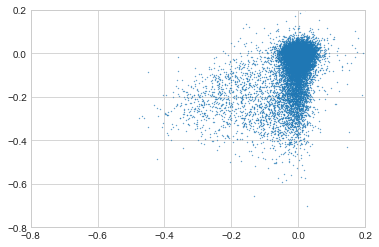

In [5]:
# from math import sqrt

# for i in range(21240):

#     if CpGs['mutant_average'][i] > CpGs['CRISPRoff_average'][i]:
#         CpGs.at[i, 'Phe_sco_pos_neg'] =  int(1)
#         CpGs.at[i,'Strength'] =  sqrt(abs(CpGs['mutant_average'][i] - CpGs['CRISPRoff_average'][i])) 

#     elif CpGs['mutant_average'][i] < CpGs['CRISPRoff_average'][i]:
#         CpGs.at[i, 'Phe_sco_pos_neg'] = int(0)
#         CpGs.at[i,'Strength'] = 0
#     else:
#         CpGs.at[i, 'Strength'] = 'Same'

import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

colors = {1:'tab:pink', 0:'tab:black', 'Nan':'tab:blue'}

plt.scatter(cpgs['mutant_average'], cpgs['CRISPRoff_average'],s = 0.1)
         
plt.axis([-0.8,0.2,-0.8,0.2])


In [6]:
cpgs = cpgs[['gene','CRISPRoff_average', 'mutant_average']]
cpgs = cpgs.sort_values(["gene",'CRISPRoff_average'], ascending = True).drop_duplicates(subset = 'gene', keep = 'first')

### Merging sequences with correspondent phenotype scores

In [10]:
df = pd.merge(how = 'outer', left = Promoter_sequences, right = cpgs, left_on = 'Gene', right_on = 'gene')
df = df.loc[df.Gene.notna()]
df['GC'] = counts
df

,Gene,Sequences,gene,CRISPRoff_average,mutant_average,GC
0,A1BG,CCCAGCACTACCACCCTGGACTGGGAGGACAAGACCACAAAATGCA...,A1BG,-0.063267,-0.013067,53.333333
1,A1CF,TTTCTTTTGAGCCACATTTATTAACATCCACTGAATATAGTGTAGG...,A1CF,0.021009,0.031239,NaN
2,A2M,TTTTGATGATATTTTAAATTAATACTTAGATTACTTTTACAATTTT...,A2M,0.012236,0.010139,34.700000
3,A2ML1,TACTCTTTTGCCATTGCAGTTCCCCTGTCTTGATAAATCGGCTCTG...,A2ML1,0.006076,0.017281,34.833333
4,A3GALT2,CCTATAGGCCAGTGGTGCACCTGCGCACGTGGCCTGCACTCCAGCA...,A3GALT2,0.045413,0.018161,45.833333
...,...,...,...,...,...,...
19184,UQCRHL,TTTAAGATGGCTTTTGATTTATTTTGATGGAGGTAATGTATCAATT...,UQCRHL,-0.076844,0.010787,56.366667
19185,WTH3DI,GTAAGAACACGGAAATAGGGAACGGGGTAAGGGAGAGGTGAGAAGA...,WTH3DI,-0.022786,0.018067,69.166667
19186,ZAK,TTGTTTTTTAACCTCTACTCATTCATCCCTCAACTTTCATATCTTT...,ZAK,-0.104309,0.042356,53.733333
19187,ZHX1-C8ORF76,TTTTTTTTTTTTCTAATAGCTGGGCTGAGTTGACAGAAAAGGGCTG...,ZHX1-C8ORF76,-0.198818,-0.011289,55.733333


In [8]:
df['GC'] = df['GC'].apply(lambda x: 0 if x < 50 else x)

/var/folders/pj/0dd0rqzj219164nwyh4f2l580000gn/T/ipykernel_52032/1166661427.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(scalarmappaple)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


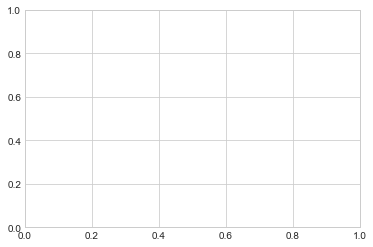

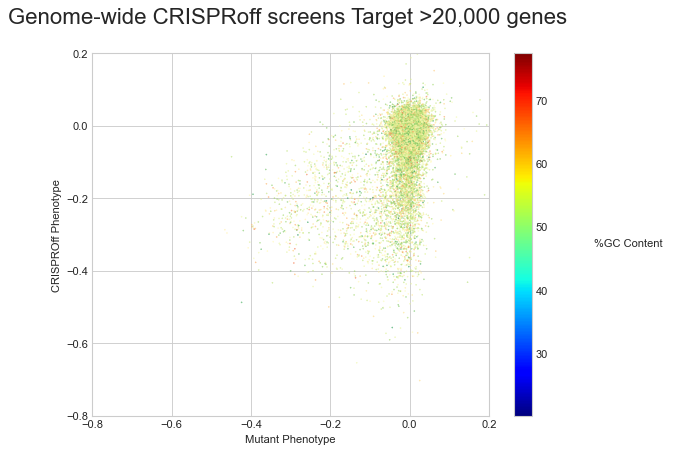

In [11]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.pyplot import figure

fig, ax = plt.subplots()
plt.style.use('seaborn-whitegrid')

figure(figsize=(8, 6), dpi=80)

colors = {1:'tab:pink', 0:'tab:black', 'Nan':'tab:blue'}

plt.scatter(df['mutant_average'], df['CRISPRoff_average'], c = df.GC, cmap = "RdYlGn",s = 0.1)

normalize = mcolors.Normalize(vmin=df.GC.min(), vmax=df.GC.max())
colormap = cm.jet

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(df.GC)
plt.colorbar(scalarmappaple)

plt.legend(bbox_to_anchor=(1.35,0.5), borderaxespad=0, title="%GC Content",
                    loc= 'upper center', fontsize='small', fancybox=True,)

plt.title('Genome-wide CRISPRoff screens Target >20,000 genes \n', size = 20)
plt.xlabel('Mutant Phenotype')
plt.ylabel('CRISPROff Phenotype')

plt.axis([-0.8,0.2,-0.8,0.2])
plt.savefig('Genome-wide %GC.eps', format = 'eps')


/var/folders/pj/0dd0rqzj219164nwyh4f2l580000gn/T/ipykernel_52032/2215349561.py:21: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(scalarmappaple)


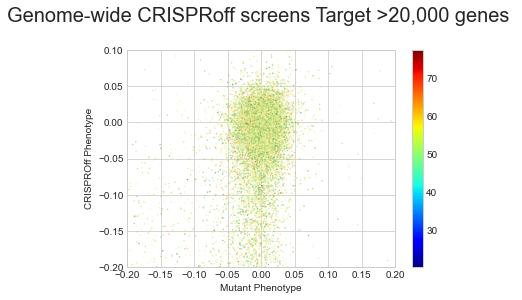

In [12]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

fig, ax = plt.subplots()
plt.style.use('seaborn-whitegrid')

colors = {1:'tab:pink', 0:'tab:black', 'Nan':'tab:blue'}

plt.scatter(df['mutant_average'], df['CRISPRoff_average'], c = df.GC, cmap = "RdYlGn",s = 0.1)

normalize = mcolors.Normalize(vmin=df.GC.min(), vmax=df.GC.max())
colormap = cm.jet

plt.title('Genome-wide CRISPRoff screens Target >20,000 genes \n', size = 20)
plt.xlabel('Mutant Phenotype')
plt.ylabel('CRISPROff Phenotype')

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(df.GC)
plt.colorbar(scalarmappaple)

plt.title('Genome-wide CRISPRoff screens Target >20,000 genes \n', size = 20)
plt.xlabel('Mutant Phenotype')
plt.ylabel('CRISPROff Phenotype')

plt.axis([-0.2,0.2,-0.2,0.1])
plt.savefig('Genome-Wide %GC Zoom.eps', format = 'eps')


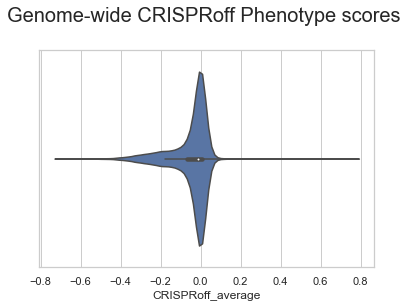

In [13]:
import seaborn as sns
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
plt.title('Genome-wide CRISPRoff Phenotype scores \n', size = 20)
ax = sns.violinplot(x=df['CRISPRoff_average'])
plt.savefig('Violin plot.eps', format = 'eps')

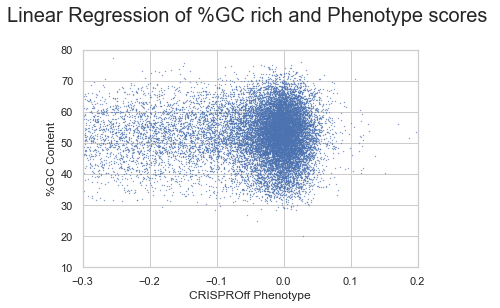

In [14]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

fig, ax = plt.subplots()
plt.style.use('seaborn-whitegrid')

plt.scatter(df['CRISPRoff_average'], df['GC'], cmap = "RdYlGn",s = 0.1)

plt.xlabel('CRISPROff Phenotype')
plt.ylabel('%GC Content')

plt.title('Linear Regression of %GC rich and Phenotype scores \n', size = 20)

plt.axis([-0.3,0.2,10,80])
plt.savefig('Linear-regression_1.eps', format = 'eps')


In [15]:
regression_data = df[['CRISPRoff_average','GC']].dropna()

coefficient of determination: 5.291085931502515e-05
slope: [0.60784422]
intercept: 52.680946652001


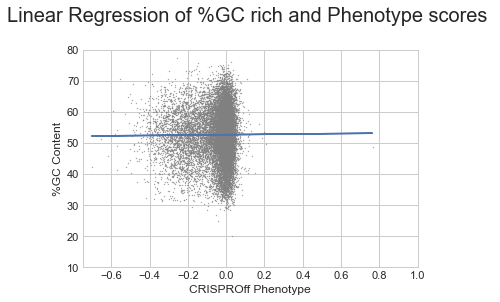

In [16]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from sklearn.linear_model import LinearRegression

x =  np.array(regression_data.CRISPRoff_average).reshape((-1,1))
y =  np.array(regression_data.GC)

model = LinearRegression()
model.fit(x,y)
model = LinearRegression().fit(x,y)
r_sq = model.score(x, y)

m,b = np.polyfit(np.array(regression_data.CRISPRoff_average),y,1)

print('coefficient of determination:', r_sq)
print('slope:', model.coef_)
print('intercept:', model.intercept_)

fig, ax = plt.subplots()
plt.style.use('seaborn-whitegrid')

plt.scatter(df['CRISPRoff_average'], df['GC'],s = 0.1, c = 'grey')


plt.title('Linear Regression of %GC rich and Phenotype scores \n', size = 20)
plt.xlabel('CRISPROff Phenotype')
plt.ylabel('%GC Content')
plt.plot(x, m*x + b)

plt.axis([-0.75,1,10,80])
plt.savefig('good.eps', format = 'eps')


### Essential Genes list across cell types

In [19]:
achilles = pd.read_csv('Achilles_common_essentials.csv',sep = '(',  header = 0)
achilles = achilles['genes']

In [29]:
achilles_scores = pd.merge(how = 'outer', left = achilles, right = cpgs, left_on = 'genes', right_on = 'gene')


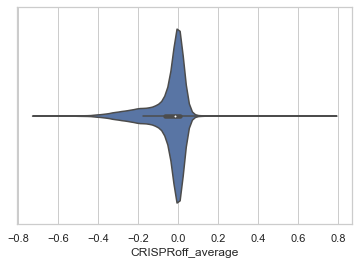

In [30]:
import seaborn as sns
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.violinplot(x=achilles_scores['CRISPRoff_average'])
plt.savefig('Essential Genes list.eps', format = 'eps')

In [31]:
achilles_cpgs = pd.merge(how = 'outer', left = achilles_scores, right = cpgs, left_on = 'genes', right_on = 'gene')
achilles_cpgs = achilles_cpgs.dropna()

In [32]:
achilles_cpgs

,genes,gene_x,CRISPRoff_average_x,mutant_average_x,gene_y,CRISPRoff_average_y,mutant_average_y
0,AAAS,AAAS,0.022066,0.033454,AAAS,0.022066,0.033454
1,AAMP,AAMP,-0.156843,-0.107485,AAMP,-0.156843,-0.107485
2,AARS,AARS,-0.262698,-0.276756,AARS,-0.262698,-0.276756
3,AARS2,AARS2,-0.143610,0.000784,AARS2,-0.143610,0.000784
4,AASDHPPT,AASDHPPT,-0.299343,-0.029740,AASDHPPT,-0.299343,-0.029740
...,...,...,...,...,...,...,...
2158,ZNRD1,ZNRD1,-0.264723,-0.206160,ZNRD1,-0.264723,-0.206160
2160,ZRANB2,ZRANB2,-0.113596,-0.040849,ZRANB2,-0.113596,-0.040849
2161,ZRSR2,ZRSR2,-0.162753,-0.028557,ZRSR2,-0.162753,-0.028557
2162,ZW10,ZW10,-0.245077,0.034984,ZW10,-0.245077,0.034984


In [33]:
cpgs = pd.read_csv('1-s2-S0092867421003536-mmc3.csv',sep = ',',  header = 0)
cpgs = cpgs[['gene','CRISPRoff_average', 'mutant_average','CpG']]
cpgs = cpgs.sort_values(["gene",'CRISPRoff_average'], ascending = True).drop_duplicates(subset = 'gene', keep = 'first')
#cpgs['CpG'] = cpgs['CpG'].apply(lambda x:  1 if 'VERDADERO' else 0)

In [34]:
cpgs[cpgs.CpG == 'FALSO']

,gene,CRISPRoff_average,mutant_average,CpG
18757,44086,0.023959,0.017189,FALSO
18682,44088,0.023584,0.012517,FALSO
19763,44166,0.031839,0.025885,FALSO
18251,A1CF,0.021009,0.031239,FALSO
16516,A2M,0.012236,0.010139,FALSO
...,...,...,...,...
14459,ZSWIM1,0.003963,0.001552,FALSO
3162,ZSWIM3,-0.125409,0.001949,FALSO
12831,ZUFSP,-0.002342,-0.002830,FALSO
2729,ZWILCH,-0.148659,-0.113377,FALSO


In [35]:
achilles_cpgs = pd.merge(how = 'outer', left = achilles_scores, right = cpgs, left_on = 'genes', right_on = 'gene')
achilles_cpgs = achilles_cpgs.dropna()

In [36]:
achilles_cpgs

,genes,gene_x,CRISPRoff_average_x,mutant_average_x,gene_y,CRISPRoff_average_y,mutant_average_y,CpG
0,AAAS,AAAS,0.022066,0.033454,AAAS,0.022066,0.033454,VERDADERO
1,AAMP,AAMP,-0.156843,-0.107485,AAMP,-0.156843,-0.107485,VERDADERO
2,AARS,AARS,-0.262698,-0.276756,AARS,-0.262698,-0.276756,VERDADERO
3,AARS2,AARS2,-0.143610,0.000784,AARS2,-0.143610,0.000784,VERDADERO
4,AASDHPPT,AASDHPPT,-0.299343,-0.029740,AASDHPPT,-0.299343,-0.029740,VERDADERO
...,...,...,...,...,...,...,...,...
2158,ZNRD1,ZNRD1,-0.264723,-0.206160,ZNRD1,-0.264723,-0.206160,VERDADERO
2160,ZRANB2,ZRANB2,-0.113596,-0.040849,ZRANB2,-0.113596,-0.040849,VERDADERO
2161,ZRSR2,ZRSR2,-0.162753,-0.028557,ZRSR2,-0.162753,-0.028557,VERDADERO
2162,ZW10,ZW10,-0.245077,0.034984,ZW10,-0.245077,0.034984,VERDADERO


Genes without CpGs: 133
Genes with CpGs: 1866


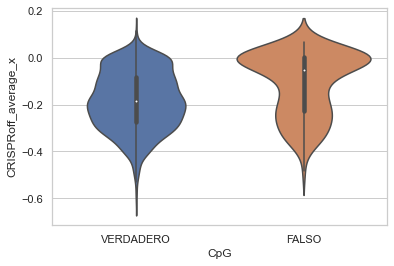

In [37]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

sns.violinplot(y='CRISPRoff_average_x', x="CpG",
              data=achilles_cpgs)

print('Genes without CpGs:', len(achilles_cpgs.CpG[achilles_cpgs.CpG == 'FALSO']))
print('Genes with CpGs:', len(achilles_cpgs.CpG[achilles_cpgs.CpG == 'VERDADERO']))

plt.savefig('Essential Genes list violin.eps', format = 'eps')

### IRRBS File

In [39]:
irbs = pd.read_csv('wgEncodeHaibMethylRrbsK562HaibSitesRep1.bed', sep=',', header = 0)
irbs

,,"track\tname=""SL725\tMspIRRBS""\tK562_Rep3_RRBS\tMspIRRBS""\tvisibility=2\tname=""SL725\tMspIRRBS""\t\t\t"
chr1\t1000170\t1000171\tK562_Rep3_RRBS\t46\t+\t1000170\t1000171\t155,255,0\t46\t35
chr1\t1000190\t1000191\tK562_Rep3_RRBS\t46\t+\t1000190\t1000191\t105,255,0\t46\t15
chr1\t1000191\t1000192\tK562_Rep3_RRBS\t53\t-\t1000191\t1000192\t55,255,0\t53\t9
chr1\t1000198\t1000199\tK562_Rep3_RRBS\t46\t+\t1000198\t1000199\t105,255,0\t46\t20
chr1\t1000199\t1000200\tK562_Rep3_RRBS\t53\t-\t1000199\t1000200\t105,255,0\t53\t15
...,...,...
chrY\t9930847\t9930848\tK562_Rep3_RRBS\t28\t-\t9930847\t9930848\t205,255,0\t28\t43
chrY\t9930879\t9930880\tK562_Rep3_RRBS\t28\t-\t9930879\t9930880\t255,155,0\t28\t68
chrY\t9982886\t9982887\tK562_Rep3_RRBS\t5\t+\t9982886\t9982887\t0,255,0\t5\t0
chrY\t9987654\t9987655\tK562_Rep3_RRBS\t7\t+\t9987654\t9987655\t55,255,0\t7\t14
